In [1]:
from pathlib import Path
from collections.abc import Mapping

import torch
import ignite
import ignite.distributed as idist
from ignite.contrib.engines import common
from ignite.engine import Engine, Events, create_supervised_evaluator, create_supervised_trainer
from ignite.handlers import DiskSaver
from ignite.metrics import ConfusionMatrix as cm, IoU, mIoU, Loss
from ignite.utils import setup_logger

import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys

from models.unets import unet_resnet
from dataflow.dataloaders import get_train_val_loaders
from dataflow.visualisations import tensor_to_rgb
from dataflow.transforms import get_train_augmentation, get_validation_augmentation, prepare_batch_fp32
from tqdm import tqdm
loss = smp.utils.losses.DiceLoss()

In [4]:
model, preprocessing_function = unet_resnet('efficientnet-b0')

In [5]:
lr = 5e-3
optimizer = torch.optim.Adam(
    [
        {"params": model.encoder.parameters(), "lr": 1e-6},
        {"params": model.decoder.parameters(), "lr": lr / 10},
        {"params": model.segmentation_head.parameters(), "lr": lr},
    ],
    lr=lr,
)

In [6]:
num_epochs = 10

criterion = smp.utils.losses.DiceLoss()


In [7]:
debug=False

num_classes = 1

batch_size = 8 * idist.get_world_size()  # total batch size
val_batch_size = batch_size * 2
num_workers = 12
val_interval = 3
accumulation_steps = 4

val_img_size = 513
train_img_size = 480
data_dir = Path('/media/wwymak/Storage/spacenet/AOI_3_Paris_Train')
image_dir = data_dir / 'RGB-PanSharpen'
mask_dir = data_dir / 'masks'
summary_data_filepath = data_dir / 'summaryData' / 'AOI_3_Paris_Train_Building_Solutions.csv'
train_loader, val_loader, train_eval_loader = get_train_val_loaders(
    image_dir=image_dir,
    mask_dir=mask_dir,
    summary_data_filepath=summary_data_filepath,
    train_transforms=get_train_augmentation(),
    val_transforms=get_validation_augmentation(),
    train_ratio=0.8,
    batch_size=batch_size,
    num_workers=num_workers,
    limit_train_num_samples=100 if debug else None,
    limit_val_num_samples=100 if debug else None,
)

In [11]:
batch_train = (next(iter(train_loader)))
batch_val = (next(iter(val_loader)))
batch_train_val = (next(iter(train_eval_loader)))

In [12]:
batch_train['image'].shape, batch_train['mask'].shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 256, 256]))

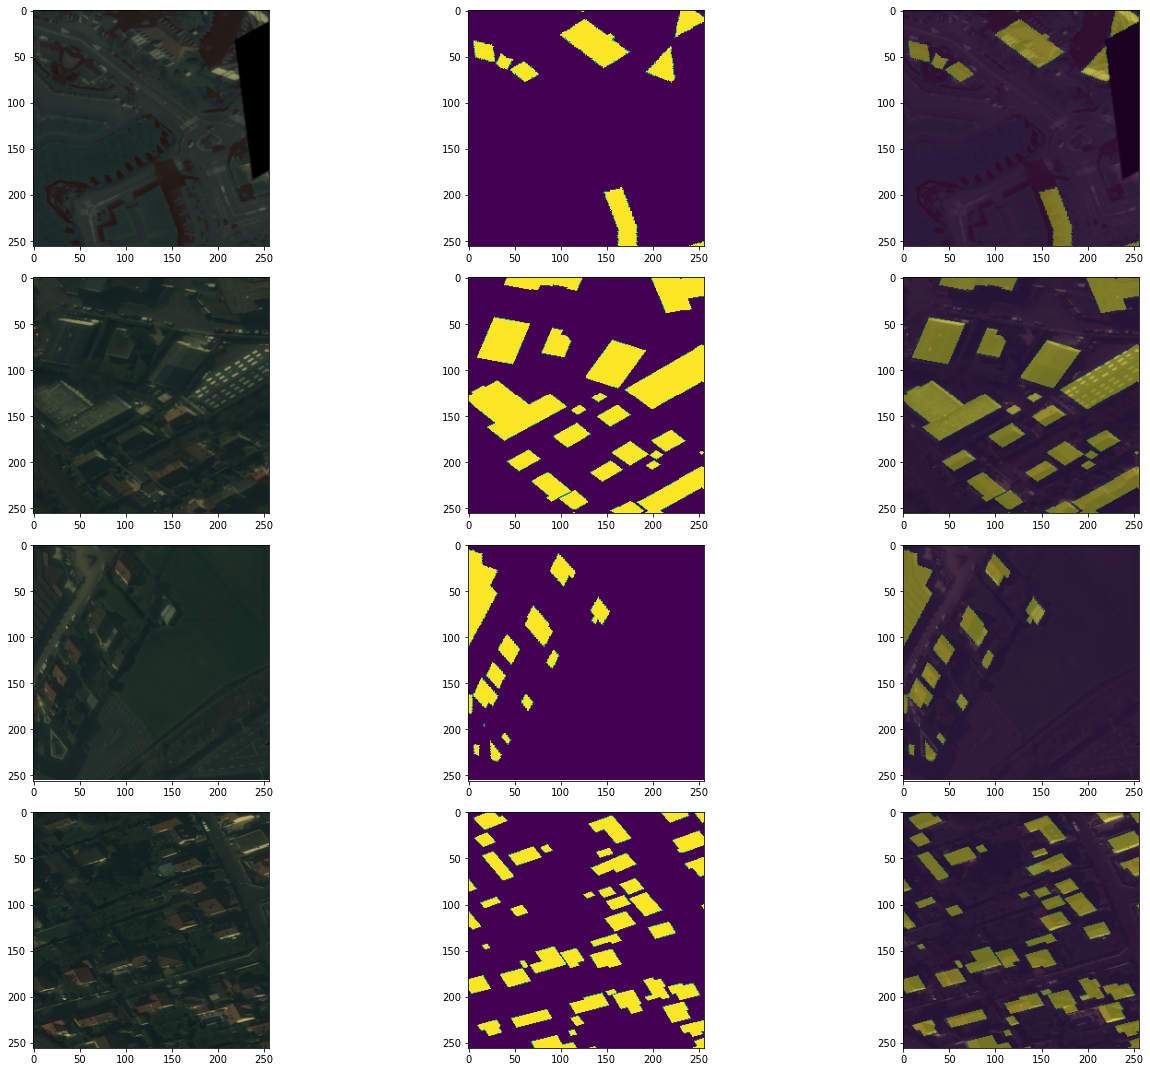

In [13]:
nrows=4
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(nrows * 5, 3 * 5))
for i in range(nrows):
    axs[i, 0].imshow(tensor_to_rgb(batch_train['image'][i]))
    axs[i, 1].imshow(batch_train['mask'][i])
    axs[i, 2].imshow(tensor_to_rgb(batch_train['image'][i]))
    axs[i, 2].imshow(batch_train['mask'][i], alpha=0.4)
plt.tight_layout()

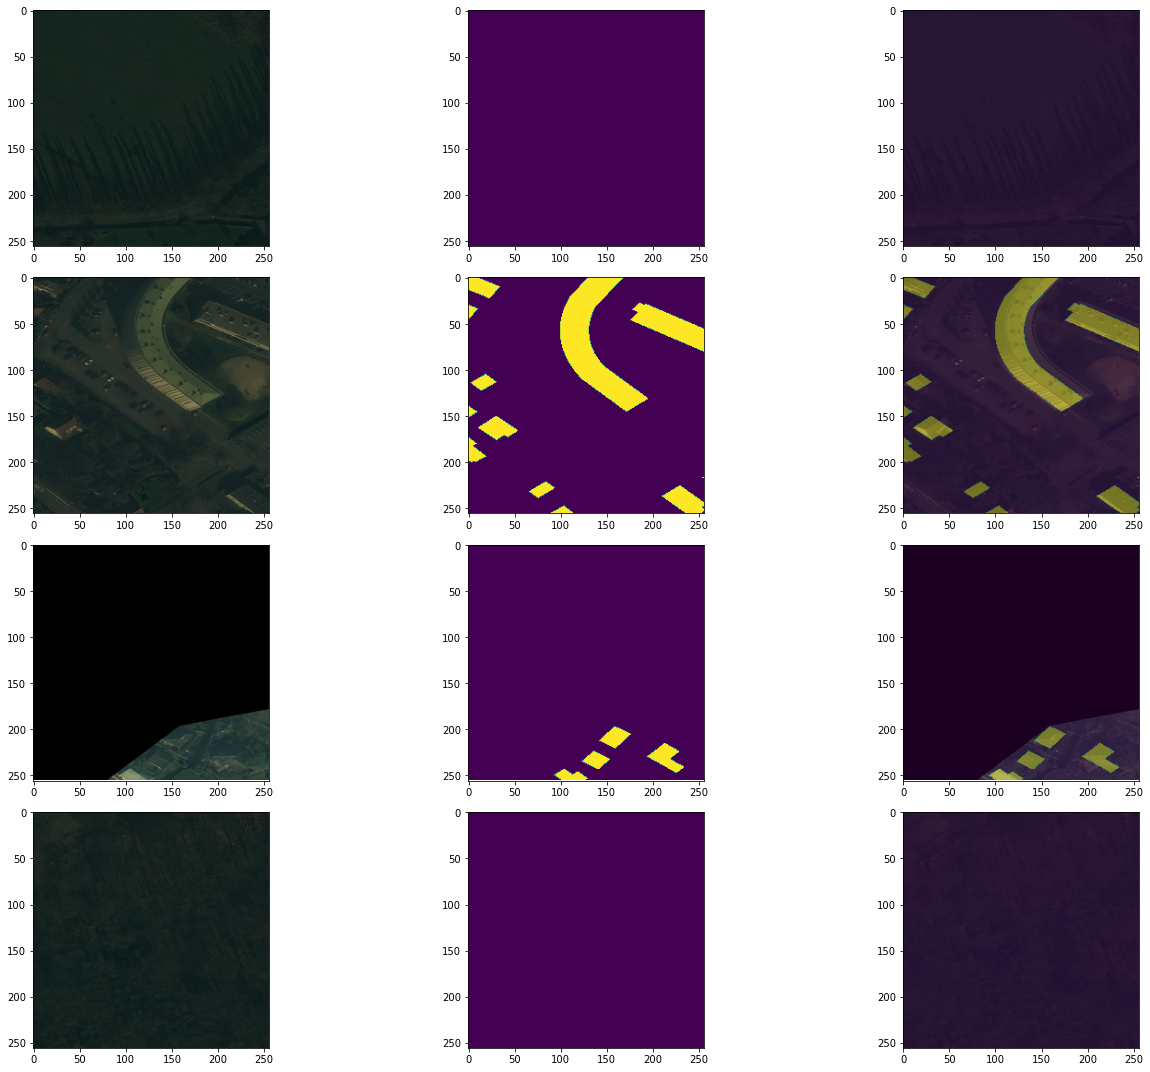

In [14]:
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(nrows * 5, 3 * 5))
for i in range(nrows):
    axs[i, 0].imshow(tensor_to_rgb(batch_val['image'][i]))
    axs[i, 1].imshow(batch_val['mask'][i])
    axs[i, 2].imshow(tensor_to_rgb(batch_val['image'][i]))
    axs[i, 2].imshow(batch_val['mask'][i], alpha=0.4)
plt.tight_layout()

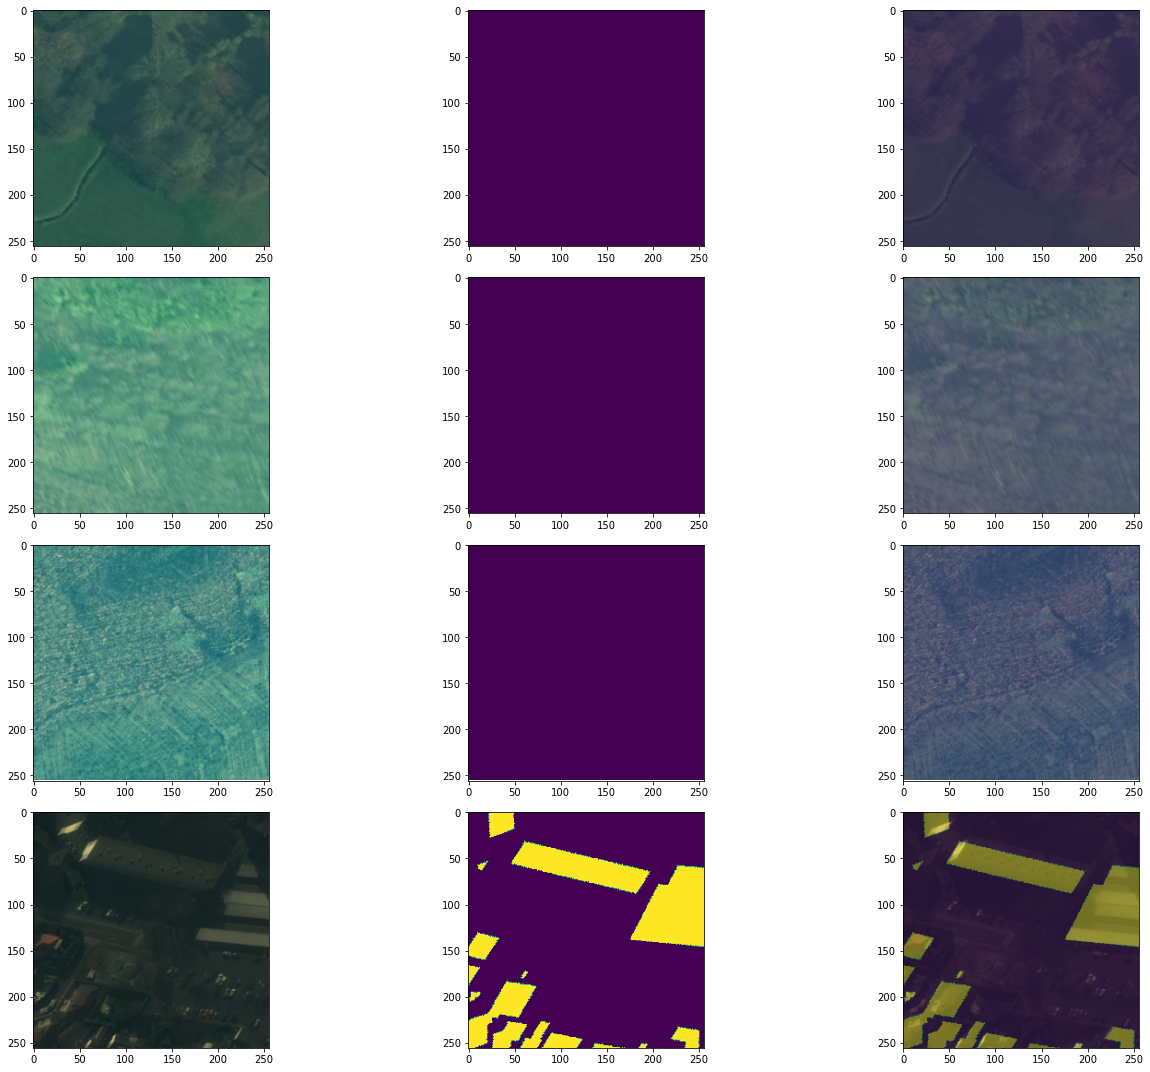

In [84]:
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(nrows * 5, 3 * 5))
for i in range(nrows):
    axs[i, 0].imshow(tensor_to_rgb(batch_train_val['image'][i]))
    axs[i, 1].imshow(batch_train_val['mask'][i])
    axs[i, 2].imshow(tensor_to_rgb(batch_train_val['image'][i]))
    axs[i, 2].imshow(batch_train_val['mask'][i], alpha=0.4)
plt.tight_layout()

In [94]:
device='cuda:0'
trainer = create_supervised_trainer(model, optimizer, criterion, device=device, prepare_batch=prepare_batch_fp32)
trainer.logger = setup_logger("trainer")


In [95]:
num_classes = 1
log_interval=10
cm_metric = ConfusionMatrix(num_classes=num_classes)
val_metrics = {
        "IoU": IoU(cm_metric),
        "mIoU_bg": mIoU(cm_metric),
        "dice_loss": Loss(loss),
    "iou2": smp.utils.metrics.IoU()
    }
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device, prepare_batch=prepare_batch_fp32)
evaluator.logger = setup_logger("evaluator")

desc = "ITERATION - loss: {:.2f}"
pbar = tqdm(initial=0, leave=False, total=len(train_loader), desc=desc.format(0))

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    pbar.desc = desc.format(engine.state.output)
    pbar.update(log_interval)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    pbar.refresh()
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    iou = metrics["IoU"]
    loss = metrics["dice_loss"]
    iou2 = metrics["iou2"]
    tqdm.write(
        f"Training Results - Epoch: { engine.state.epoch}  iou: {iou} Avg loss: {loss}, iou2: {iou2}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    iou = metrics["IoU"]
    loss = metrics["dice_loss"]
    print(iou, 'iou')
    print('loss', loss)
    iou2 = metrics["iou2"]
    tqdm.write(
        f"Validation Results - Epoch: { engine.state.epoch}  iou: {iou} Avg loss: {loss}, iou2: {iou2}"
    )

    pbar.n = pbar.last_print_n = 0

@trainer.on(Events.EPOCH_COMPLETED | Events.COMPLETED)
def log_time(engine):
    tqdm.write(
        "{} took {} seconds".format(trainer.last_event_name.name, trainer.state.times[trainer.last_event_name.name])
    )



AttributeError: 'IoU' object has no attribute 'attach'

In [77]:
trainer.run(train_loader, max_epochs=10)
pbar.close()

2020-07-19 19:26:32,876 trainer INFO: Engine run starting with max_epochs=10.








ITERATION - loss: -1.03:  83%|████████▎ | 10/12 [00:02<00:00,  3.34it/s]







ITERATION - loss: -1.03:  83%|████████▎ | 10/12 [00:03<00:00,  3.34it/s]2020-07-19 19:26:34,392 evaluator INFO: Engine run starting with max_epochs=1.
2020-07-19 19:26:34,889 evaluator ERROR: Current run is terminating due to exception: y_pred does not have correct number of categories: 1 vs 2.
2020-07-19 19:26:34,937 evaluator ERROR: Engine run is terminating due to exception: y_pred does not have correct number of categories: 1 vs 2.
2020-07-19 19:26:34,980 trainer ERROR: Engine run is terminating due to exception: y_pred does not have correct number of categories: 1 vs 2.


ValueError: y_pred does not have correct number of categories: 1 vs 2

In [71]:
evaluator.state.metrics

{'IoU': tensor([1.], dtype=torch.float64),
 'mIoU_bg': 1.0,
 'dice_loss': 0.04029423236846924}

In [73]:
len(train_loader)

12

In [74]:
batch_val['image'].shape

torch.Size([8, 3, 256, 256])

In [93]:
smp.utils.metrics.IoU()

IoU(
  (activation): Activation(
    (activation): Identity()
  )
)